<a href="https://colab.research.google.com/github/sartoriando/dotfiles/blob/master/Presen%C3%A7a%20das%20Mulheres%20na%20C%C3%A2mara_Rafaela_Sartori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Presença das Mulheres na Câmara dos Deputados
## Trabalho Final - Ciência de Dados - Enap / 2021


### Apresentação do Dataset

Este trabalho utiliza os seguintes dadasets, disponíveis na página de Dados Abertos da Câmara dos Deputados:
- df_deputados: dados gerais dos deputados eleitos, desde a primeira Legislatura no século XIX.
- df_legislaturas: com informações sobre o início e o fim de cada Legislatura
- df_dpessoais_56: Dados pessoais dos deputados eleitos na 56a Legislatura (a atual, que começou em 2019)

#### Link para Download do Dataset

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time


In [2]:
# Links das bases de dados
url_deputados = 'https://dadosabertos.camara.leg.br/arquivos/deputados/xlsx/deputados.xlsx'
url_legislaturas = 'https://dadosabertos.camara.leg.br/api/v2/legislaturas?itens=56&ordem=ASC&ordenarPor=id'


### Motivação Pessoal

Desde que comecei a trabalhar na Câmara dos Deputados, há sete anos, tenho tido contato com diversos debates e temas de estudos. Um deles é a presença das mulheres nos Parlamentos. Esse é um tema recorrente em estudos nacionais e internacionais sobre o Legislativo, uma vez que se considera que a diversidade de gênero é um pilar importante para a representatividade na democracia. A relevância do tema é indiscutível, e me interessa particularmente por eu ser mulher.  

### Investigação

Formando e tratando os DataFrames

In [3]:
# Formando o dataframe com os dados de todas as legislaturas (período para o qual o deputado é eleito)

headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
re = requests.get(url_legislaturas, headers=headers)
re.json()
js = re.json()
# cria df a partir do json

# Formando o dataframe com os dados de todos os deputados
# Este Df tem uma entrada única para cada deputado. Assim, mesmo se reeleito, ele só aparece em uma linha
df_deputados_sem_repeticoes = pd.read_excel(url_deputados)

# Base de dados das legislaturas
# df_legislaturas = pd.DataFrame(dic_legislaturas)
df_legislaturas = pd.json_normalize(js, 'dados')

In [4]:
# Reformulando a lista geral de deputados (df_deputados_sem_repeticoes) para conter uma linha
# para cada deputado em cada legislatura, mesmo que reeleito

temp_df = []
for row in df_deputados_sem_repeticoes.itertuples(index=False):
  if row.idLegislaturaFinal > row.idLegislaturaInicial:
    inicio = row.idLegislaturaInicial
    i = 1
    final = row.idLegislaturaFinal
    while i <= (final-inicio):
      myvar = inicio + i
      new_legis = myvar
      new_row = [row.uri, row.nome, new_legis, row.idLegislaturaFinal,
       row.nomeCivil, row.cpf, row.siglaSexo, row.urlRedeSocial, row.urlWebsite,
       row.dataNascimento, row.dataFalecimento, row.ufNascimento, row.municipioNascimento]
      temp_df.extend([new_row])
      i += 1
  else:
    pass

# temp_df
reeleitos_df = pd.DataFrame(temp_df, columns=['uri', 'nome', 'idLegislaturaInicial', 'idLegislaturaFinal',
       'nomeCivil', 'cpf', 'siglaSexo', 'urlRedeSocial', 'urlWebsite',
       'dataNascimento', 'dataFalecimento', 'ufNascimento',
       'municipioNascimento'])
reeleitos_df.head(2)

,uri,nome,idLegislaturaInicial,idLegislaturaFinal,nomeCivil,cpf,siglaSexo,urlRedeSocial,urlWebsite,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento
0,https://dadosabertos.camara.leg.br/api/v2/depu...,LOPES GAMA,2,2,Caetano Maria Lopes Gama,NaN,M,NaN,NaN,1795-08-05,1864-06-21,PE,Recife
1,https://dadosabertos.camara.leg.br/api/v2/depu...,CALMON,2,4,Miguel Calmon Du Pin e Almeida,NaN,M,NaN,NaN,1796-12-22,1865-10-05,BA,Santo Amaro


In [5]:
# Concatenando reeleitos_df com df_deputados_sem_repeticoes
# Df final: df_deputados
df_deputados = pd.concat([df_deputados_sem_repeticoes, reeleitos_df])

df_deputados[df_deputados['nome'] == 'CALMON']  # Para confirmar que há uma linha para cada deputado em cada legislatura para a qual foi eleito

,uri,nome,idLegislaturaInicial,idLegislaturaFinal,nomeCivil,cpf,siglaSexo,urlRedeSocial,urlWebsite,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento
2,https://dadosabertos.camara.leg.br/api/v2/depu...,CALMON,1,4,Miguel Calmon Du Pin e Almeida,NaN,M,NaN,NaN,1796-12-22,1865-10-05,BA,Santo Amaro
1,https://dadosabertos.camara.leg.br/api/v2/depu...,CALMON,2,4,Miguel Calmon Du Pin e Almeida,NaN,M,NaN,NaN,1796-12-22,1865-10-05,BA,Santo Amaro
2,https://dadosabertos.camara.leg.br/api/v2/depu...,CALMON,3,4,Miguel Calmon Du Pin e Almeida,NaN,M,NaN,NaN,1796-12-22,1865-10-05,BA,Santo Amaro
3,https://dadosabertos.camara.leg.br/api/v2/depu...,CALMON,4,4,Miguel Calmon Du Pin e Almeida,NaN,M,NaN,NaN,1796-12-22,1865-10-05,BA,Santo Amaro


In [6]:
# Expandindo dados de df_deputados, para incluir anos das legislaturas
df_deputados = df_deputados.merge(df_legislaturas, left_on='idLegislaturaInicial', right_on='id')
df_deputados.rename(columns={"uri_x": "uri_deputado", "uri_y": "uri_legislatura"}, inplace=True)
df_deputados.tail(2)

,uri_deputado,nome,idLegislaturaInicial,idLegislaturaFinal,nomeCivil,cpf,siglaSexo,urlRedeSocial,urlWebsite,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,id,uri_legislatura,dataInicio,dataFim
19702,https://dadosabertos.camara.leg.br/api/v2/depu...,LAMOUNIER GODOFREDO,21,31,Antonio Affonso Lamounier Godofredo,NaN,M,NaN,NaN,1859-05-09,NaN,MG,Itapecerica,21,https://dadosabertos.camara.leg.br/api/v2/legi...,1889-11-02,1889-11-15
19703,https://dadosabertos.camara.leg.br/api/v2/depu...,CANDIDO PESSÔA,21,35,Candido Pessôa,NaN,M,NaN,NaN,9999-09-09,NaN,NaN,NaN,21,https://dadosabertos.camara.leg.br/api/v2/legi...,1889-11-02,1889-11-15


In [7]:
#  Criando coluna com ano de início da legislatura
df_deputados['anoInicioLegislatura'] = df_deputados.dataInicio.apply(lambda x: int(x.split('-')[0]))

df_deputados.head(3)

,uri_deputado,nome,idLegislaturaInicial,idLegislaturaFinal,nomeCivil,cpf,siglaSexo,urlRedeSocial,urlWebsite,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,id,uri_legislatura,dataInicio,dataFim,anoInicioLegislatura
0,https://dadosabertos.camara.leg.br/api/v2/depu...,LOPES GAMA,1,2,Caetano Maria Lopes Gama,NaN,M,NaN,NaN,1795-08-05,1864-06-21,PE,Recife,1,https://dadosabertos.camara.leg.br/api/v2/legi...,1826-04-29,1830-04-24,1826
1,https://dadosabertos.camara.leg.br/api/v2/depu...,CARNEIRO,1,1,Francisco Carneiro de Campos,NaN,M,NaN,NaN,1776-01-01,1842-12-08,BA,Salvador,1,https://dadosabertos.camara.leg.br/api/v2/legi...,1826-04-29,1830-04-24,1826
2,https://dadosabertos.camara.leg.br/api/v2/depu...,CALMON,1,4,Miguel Calmon Du Pin e Almeida,NaN,M,NaN,NaN,1796-12-22,1865-10-05,BA,Santo Amaro,1,https://dadosabertos.camara.leg.br/api/v2/legi...,1826-04-29,1830-04-24,1826


In [8]:
# DF com totais de deputadas divididos por gênero por legislatura (em ano de início)

# Os totais por legislatura somam mais que o número máximo de cadeiras (atualmente, 513). 
# Isso provavelmente se deve aos suplentes, que assumem no lugar dos deputados que se afastam.  
# Porém, não é possível observar o impacto dos suplentes no total por legislatura,
# pois a base de dados vem atualizada com o último status do deputado.
# Assim, um deputadoo que seja suplente numa legislatura e titular na próxima, apareceria como titular nas duas legislaturas. 

totais_por_sexo = df_deputados.groupby(['anoInicioLegislatura', 'siglaSexo']).count().reset_index()
totais_por_sexo.pivot(columns='siglaSexo', index='anoInicioLegislatura', values='uri_deputado').reset_index()

siglaSexo,anoInicioLegislatura,F,M
0,1826,NaN,133.0
1,1830,NaN,141.0
2,1834,NaN,153.0
3,1838,NaN,153.0
4,1842,NaN,172.0
5,1844,NaN,182.0
6,1848,NaN,172.0
7,1849,NaN,180.0
8,1853,NaN,188.0
9,1857,NaN,214.0


In [11]:
# Testando se a função de replicar deputados em mais de uma candidatura, quando reeleitos, funcionou
# Observaremos isso com uma lista nominal das primeiras Deputadas eleitas
df_deputados[df_deputados['siglaSexo'] == 'F'].sort_values(by=['idLegislaturaInicial']).head(10)

,uri_deputado,nome,idLegislaturaInicial,idLegislaturaFinal,nomeCivil,cpf,siglaSexo,urlRedeSocial,urlWebsite,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,id,uri_legislatura,dataInicio,dataFim,anoInicioLegislatura
9072,https://dadosabertos.camara.leg.br/api/v2/depu...,CARLOTA DE QUEIRÓS,36,37,Carlota Pereira de Queirós,NaN,F,NaN,NaN,1892-02-13,1982-04-17,SP,São Paulo,36,https://dadosabertos.camara.leg.br/api/v2/legi...,1934-07-21,1935-04-27,1934
13906,https://dadosabertos.camara.leg.br/api/v2/depu...,BERTHA LUTZ,37,37,Bertha Maria Júlia Lutz,NaN,F,NaN,NaN,1894-08-02,1976-09-16,SP,São Paulo,37,https://dadosabertos.camara.leg.br/api/v2/legi...,1935-04-28,1937-11-10,1935
13943,https://dadosabertos.camara.leg.br/api/v2/depu...,CARLOTA DE QUEIRÓS,37,37,Carlota Pereira de Queirós,NaN,F,NaN,NaN,1892-02-13,1982-04-17,SP,São Paulo,37,https://dadosabertos.camara.leg.br/api/v2/legi...,1935-04-28,1937-11-10,1935
9397,https://dadosabertos.camara.leg.br/api/v2/depu...,IVETTE VARGAS,39,47,Cândida Ivette Vargas Tatsch Martins,NaN,F,NaN,NaN,1927-07-17,1984-01-03,RS,São Borja,39,https://dadosabertos.camara.leg.br/api/v2/legi...,1951-03-10,1955-01-31,1951
5501,https://dadosabertos.camara.leg.br/api/v2/depu...,NITA COSTA,40,40,Leolina Barbosa de Souza Costa,NaN,F,NaN,NaN,1907-11-07,1963-03-07,BA,Feira de Santana,40,https://dadosabertos.camara.leg.br/api/v2/legi...,1955-02-01,1959-01-31,1955
5655,https://dadosabertos.camara.leg.br/api/v2/depu...,IVETTE VARGAS,40,47,Cândida Ivette Vargas Tatsch Martins,NaN,F,NaN,NaN,1927-07-17,1984-01-03,RS,São Borja,40,https://dadosabertos.camara.leg.br/api/v2/legi...,1955-02-01,1959-01-31,1955
7250,https://dadosabertos.camara.leg.br/api/v2/depu...,IVETTE VARGAS,41,47,Cândida Ivette Vargas Tatsch Martins,NaN,F,NaN,NaN,1927-07-17,1984-01-03,RS,São Borja,41,https://dadosabertos.camara.leg.br/api/v2/legi...,1959-02-01,1963-01-31,1959
3584,https://dadosabertos.camara.leg.br/api/v2/depu...,NECY NOVAES,42,44,Necy Santos Novaes,NaN,F,NaN,NaN,1908-02-08,1979-10-31,SP,São Paulo,42,https://dadosabertos.camara.leg.br/api/v2/legi...,1963-02-01,1967-01-31,1963
3874,https://dadosabertos.camara.leg.br/api/v2/depu...,IVETTE VARGAS,42,47,Cândida Ivette Vargas Tatsch Martins,NaN,F,NaN,NaN,1927-07-17,1984-01-03,RS,São Borja,42,https://dadosabertos.camara.leg.br/api/v2/legi...,1963-02-01,1967-01-31,1963
7555,https://dadosabertos.camara.leg.br/api/v2/depu...,NYSIA CARONE,43,43,Nysia Coimbra Flôres Carone,NaN,F,NaN,NaN,1928-10-16,2009-03-04,MG,Muriaé,43,https://dadosabertos.camara.leg.br/api/v2/legi...,1967-02-01,1971-01-31,1967


In [12]:
#  Dados detalhados dos deputados na 56a Legislatura (atual)
df_deps_56 = df_deputados[df_deputados.idLegislaturaInicial == 56]
df_deps_56.head(3)

,uri_deputado,nome,idLegislaturaInicial,idLegislaturaFinal,nomeCivil,cpf,siglaSexo,urlRedeSocial,urlWebsite,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,id,uri_legislatura,dataInicio,dataFim,anoInicioLegislatura
18359,https://dadosabertos.camara.leg.br/api/v2/depu...,Fábio Henrique,56,56,FABIO HENRIQUE SANTANA DE CARVALHO,NaN,M,"fabiohenriquese12, @FabioHenriqueSE",NaN,1972-06-19,NaN,SE,Simão Dias,56,https://dadosabertos.camara.leg.br/api/v2/legi...,2019-02-01,2023-01-31,2019
18360,https://dadosabertos.camara.leg.br/api/v2/depu...,Marcelo Freixo,56,56,MARCELO RIBEIRO FREIXO,NaN,M,NaN,NaN,1967-04-12,NaN,RJ,Niterói,56,https://dadosabertos.camara.leg.br/api/v2/legi...,2019-02-01,2023-01-31,2019
18361,https://dadosabertos.camara.leg.br/api/v2/depu...,Márcio Jerry,56,56,MÁRCIO JERRY SARAIVA BARROSO,NaN,M,"marciojerry, marciojerry, marciojerry, marc...",NaN,1966-11-14,NaN,MA,Colinas,56,https://dadosabertos.camara.leg.br/api/v2/legi...,2019-02-01,2023-01-31,2019


In [13]:
#  Criando df com dados pessoais dos deputados na 56a Legislatura

# Criando um Dataframe vazio:
df_dados_pessoais_56 = pd.DataFrame({'A' : []})

# Criando serie com os url dos dados pessoais de cada dep. Uri é a chave universal
serie_uri = df_deps_56.uri_deputado

In [14]:
# Scrapping na API da Câmara dos Deputados, abrindo o json de cada deputado para obter mais dados para df_dados_pessoais. 

for url in serie_uri:
  headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
  r = requests.get(url, headers=headers)
  r.json()
  j = r.json()
  # cria df a partir do json
  df = pd.json_normalize(j)
  df_dados_pessoais_56 = df_dados_pessoais_56.append(df,ignore_index=True)
  time.sleep(0.5)
# df_dados_pessoais = pd.concat([df_dados_pessoais, df])

#  Renomeando colunas, retirando o dados e o id antes dos nomes.
for i in range(len(df_dados_pessoais_56.keys())):
  a = df_dados_pessoais_56.keys()[i]
  old = str(a)
  new = str(a.split('.')[-1])
  df_dados_pessoais_56.rename(columns={old:new}, inplace=True)

df_dados_pessoais_56.head(3)

,A,links,id,uri,nomeCivil,id,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email,data,nomeEleitoral,nome,predio,sala,andar,telefone,email,situacao,condicaoEleitoral,descricaoStatus,cpf,sexo,urlWebsite,redeSocial,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,escolaridade
0,NaN,"[{'rel': 'self', 'href': 'https://dadosabertos...",68720.0,https://dadosabertos.camara.leg.br/api/v2/depu...,FABIO HENRIQUE SANTANA DE CARVALHO,68720.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Fábio Henrique,PDT,https://dadosabertos.camara.leg.br/api/v2/part...,SE,56.0,https://www.camara.leg.br/internet/deputado/ba...,dep.fabiohenrique@camara.leg.br,2019-02-01T11:45,Fábio Henrique,475,3,475,None,3215-5475,dep.fabiohenrique@camara.leg.br,Exercício,Titular,None,41330200578,M,None,"[fabiohenriquese12, @FabioHenriqueSE]",1972-06-19,None,SE,Simão Dias,Superior
1,NaN,"[{'rel': 'self', 'href': 'https://dadosabertos...",76874.0,https://dadosabertos.camara.leg.br/api/v2/depu...,MARCELO RIBEIRO FREIXO,76874.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Marcelo Freixo,PSOL,https://dadosabertos.camara.leg.br/api/v2/part...,RJ,56.0,https://www.camara.leg.br/internet/deputado/ba...,dep.marcelofreixo@camara.leg.br,2019-02-01T11:45,Marcelo Freixo,725,4,725,7,3215-5725,dep.marcelofreixo@camara.leg.br,Exercício,Titular,None,95622780772,M,None,[],1967-04-12,None,RJ,Niterói,Superior
2,NaN,"[{'rel': 'self', 'href': 'https://dadosabertos...",81055.0,https://dadosabertos.camara.leg.br/api/v2/depu...,MÁRCIO JERRY SARAIVA BARROSO,81055.0,https://dadosabertos.camara.leg.br/api/v2/depu...,Márcio Jerry,PCdoB,https://dadosabertos.camara.leg.br/api/v2/part...,MA,56.0,https://www.camara.leg.br/internet/deputado/ba...,None,2021-02-01T11:06,Márcio Jerry,None,None,None,None,None,None,Licença,Titular,,29246830334,M,None,"[marciojerry, marciojerry, marciojerry, marcio...",1966-11-14,None,MA,Colinas,Superior


In [15]:
# Criando cópia de df_dados_pessoais_56 para trabalhar sem precisar recarregar o scrapping 
df_dpessoais_56 = df_dados_pessoais_56


In [16]:
# df_dados_pessoais para a 56a Legislatura
# Deputadas eleitas por UF

df_dpessoais_56.columns = ['A', 'links', 'id_deputado', 'uri_deputado', 'nomeCivil', 'id_deputado_repetido',
       'uri_deputado_repetido', 'nome', 'siglaPartido', 'uriPartido', 'siglaUf',
       'idLegislatura', 'urlFoto', 'email', 'data', 'nomeEleitoral', 'nome_repetido',
       'predio', 'sala', 'andar', 'telefone', 'email', 'situacao',
       'condicaoEleitoral', 'descricaoStatus', 'cpf', 'sexo', 'urlWebsite',
       'redeSocial', 'dataNascimento', 'dataFalecimento', 'ufNascimento',
       'municipioNascimento', 'escolaridade']
df_dpessoais_56.drop(['id_deputado_repetido', 'uri_deputado_repetido', 'nome_repetido'], axis=1, inplace=True)

df_dpessoais_56.head(1)

,A,links,id_deputado,uri_deputado,nomeCivil,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email,data,nomeEleitoral,predio,sala,andar,telefone,email,situacao,condicaoEleitoral,descricaoStatus,cpf,sexo,urlWebsite,redeSocial,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,escolaridade
0,NaN,"[{'rel': 'self', 'href': 'https://dadosabertos...",68720.0,https://dadosabertos.camara.leg.br/api/v2/depu...,FABIO HENRIQUE SANTANA DE CARVALHO,Fábio Henrique,PDT,https://dadosabertos.camara.leg.br/api/v2/part...,SE,56.0,https://www.camara.leg.br/internet/deputado/ba...,dep.fabiohenrique@camara.leg.br,2019-02-01T11:45,Fábio Henrique,3,475,None,3215-5475,dep.fabiohenrique@camara.leg.br,Exercício,Titular,None,41330200578,M,None,"[fabiohenriquese12, @FabioHenriqueSE]",1972-06-19,None,SE,Simão Dias,Superior


In [17]:
# Incluindo coluna com idadeNaPosse em df_dpessoais_56. 

# Convertendo o dado intLegislatura de df_dpessoais_56 em no. inteiro
df_dpessoais_56['idLegislatura'] = df_dpessoais_56.idLegislatura.apply(lambda x: int(x))

df_dpessoais_56.head(2)

,A,links,id_deputado,uri_deputado,nomeCivil,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email,data,nomeEleitoral,predio,sala,andar,telefone,email,situacao,condicaoEleitoral,descricaoStatus,cpf,sexo,urlWebsite,redeSocial,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,escolaridade
0,NaN,"[{'rel': 'self', 'href': 'https://dadosabertos...",68720.0,https://dadosabertos.camara.leg.br/api/v2/depu...,FABIO HENRIQUE SANTANA DE CARVALHO,Fábio Henrique,PDT,https://dadosabertos.camara.leg.br/api/v2/part...,SE,56,https://www.camara.leg.br/internet/deputado/ba...,dep.fabiohenrique@camara.leg.br,2019-02-01T11:45,Fábio Henrique,3,475,None,3215-5475,dep.fabiohenrique@camara.leg.br,Exercício,Titular,None,41330200578,M,None,"[fabiohenriquese12, @FabioHenriqueSE]",1972-06-19,None,SE,Simão Dias,Superior
1,NaN,"[{'rel': 'self', 'href': 'https://dadosabertos...",76874.0,https://dadosabertos.camara.leg.br/api/v2/depu...,MARCELO RIBEIRO FREIXO,Marcelo Freixo,PSOL,https://dadosabertos.camara.leg.br/api/v2/part...,RJ,56,https://www.camara.leg.br/internet/deputado/ba...,dep.marcelofreixo@camara.leg.br,2019-02-01T11:45,Marcelo Freixo,4,725,7,3215-5725,dep.marcelofreixo@camara.leg.br,Exercício,Titular,None,95622780772,M,None,[],1967-04-12,None,RJ,Niterói,Superior


In [18]:
# Expandindo dados de df_dados_pessoais_56, para incluir anos das legislaturas para cálculo da idade
df_dpessoais_56 = df_dpessoais_56.merge(df_legislaturas, left_on='idLegislatura', right_on='id')
df_dpessoais_56.rename(columns={"id_x":"id_deputado", "id_y":"id_legislatura", "uri_x": "uri_deputado", "uri_y": "uri_legislatura"}, inplace=True)

df_dpessoais_56.head(2)

,A,links,id_deputado,uri_deputado,nomeCivil,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email,data,nomeEleitoral,predio,sala,andar,telefone,email,situacao,condicaoEleitoral,descricaoStatus,cpf,sexo,urlWebsite,redeSocial,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,escolaridade,id,uri,dataInicio,dataFim
0,NaN,"[{'rel': 'self', 'href': 'https://dadosabertos...",68720.0,https://dadosabertos.camara.leg.br/api/v2/depu...,FABIO HENRIQUE SANTANA DE CARVALHO,Fábio Henrique,PDT,https://dadosabertos.camara.leg.br/api/v2/part...,SE,56,https://www.camara.leg.br/internet/deputado/ba...,dep.fabiohenrique@camara.leg.br,2019-02-01T11:45,Fábio Henrique,3,475,None,3215-5475,dep.fabiohenrique@camara.leg.br,Exercício,Titular,None,41330200578,M,None,"[fabiohenriquese12, @FabioHenriqueSE]",1972-06-19,None,SE,Simão Dias,Superior,56,https://dadosabertos.camara.leg.br/api/v2/legi...,2019-02-01,2023-01-31
1,NaN,"[{'rel': 'self', 'href': 'https://dadosabertos...",76874.0,https://dadosabertos.camara.leg.br/api/v2/depu...,MARCELO RIBEIRO FREIXO,Marcelo Freixo,PSOL,https://dadosabertos.camara.leg.br/api/v2/part...,RJ,56,https://www.camara.leg.br/internet/deputado/ba...,dep.marcelofreixo@camara.leg.br,2019-02-01T11:45,Marcelo Freixo,4,725,7,3215-5725,dep.marcelofreixo@camara.leg.br,Exercício,Titular,None,95622780772,M,None,[],1967-04-12,None,RJ,Niterói,Superior,56,https://dadosabertos.camara.leg.br/api/v2/legi...,2019-02-01,2023-01-31


In [19]:
# Criando coluna de idade na posse
df_dpessoais_56['idadeNaPosse'] = df_dpessoais_56.apply(lambda row: int(row['dataInicio'].split('-')[0]) - int(row['dataNascimento'].split('-')[0]) if isinstance(row['dataNascimento'], str) else type(row['dataNascimento']), axis=1)

df_dpessoais_56.head(1)

,A,links,id_deputado,uri_deputado,nomeCivil,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email,data,nomeEleitoral,predio,sala,andar,telefone,email,situacao,condicaoEleitoral,descricaoStatus,cpf,sexo,urlWebsite,redeSocial,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,escolaridade,id,uri,dataInicio,dataFim,idadeNaPosse
0,NaN,"[{'rel': 'self', 'href': 'https://dadosabertos...",68720.0,https://dadosabertos.camara.leg.br/api/v2/depu...,FABIO HENRIQUE SANTANA DE CARVALHO,Fábio Henrique,PDT,https://dadosabertos.camara.leg.br/api/v2/part...,SE,56,https://www.camara.leg.br/internet/deputado/ba...,dep.fabiohenrique@camara.leg.br,2019-02-01T11:45,Fábio Henrique,3,475,None,3215-5475,dep.fabiohenrique@camara.leg.br,Exercício,Titular,None,41330200578,M,None,"[fabiohenriquese12, @FabioHenriqueSE]",1972-06-19,None,SE,Simão Dias,Superior,56,https://dadosabertos.camara.leg.br/api/v2/legi...,2019-02-01,2023-01-31,47


##Gráficos

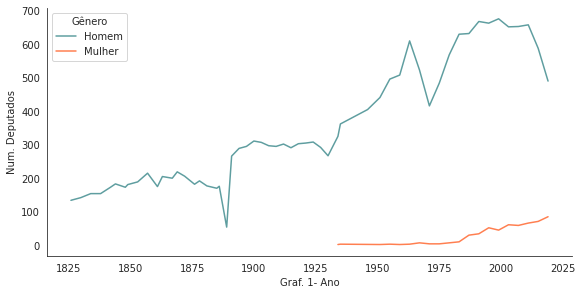

In [20]:
# Evolução da presença das mulheres na Câmara dos Deputados desde sua fundação

two_colors = {'F': '#FF7F50', 'M': '#5F9EA0'}

sns.set_style('white')
evolucao = sns.relplot(data=totais_por_sexo, kind='line', x='anoInicioLegislatura', 
                       y='uri_deputado', hue='siglaSexo', palette=two_colors, height=4, aspect=2, legend=False)
evolucao.set_axis_labels("Graf. 1- Ano", "Num. Deputados")
plt.legend(title='Gênero', loc='upper left', labels=['Homem', 'Mulher'])
plt.show(evolucao)

### Gráf. 1 - Déficit de representatividade feminina
No gráfico 1, podemos observar os grandes déficits de representatividade de mulheres na Câmara dos Deputados, instituição que deveria representar todos os cidadãos. 
No decorrer da História, a definição de quem era ou não cidadão sempre foi uma questão política e de disputas. Apenas em 1934 foi eleita a primeira mulher, Carlota de Queirós. Desde então, o baixo número de Deputadas se manteve estável, começando a crescer discretamente em 1967 (43a. Legislatura).

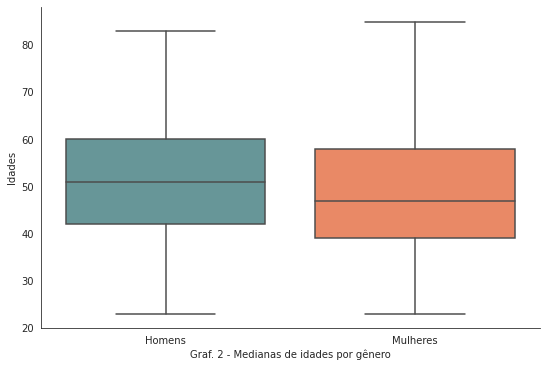

In [21]:
# Medianas das idades na 56a Legislatura (jan 2019 - )
two_colors = {'F': '#FF7F50', 'M': '#5F9EA0'}
mediana_idades = sns.catplot(kind='box', data=df_dpessoais_56, x='sexo', y='idadeNaPosse', height=5, aspect=1.5, palette=two_colors)
sns.despine()
mediana_idades.set(xticklabels=['Homens', 'Mulheres'])
mediana_idades.set_axis_labels('Graf. 2 - Medianas de idades por gênero', 'Idades')

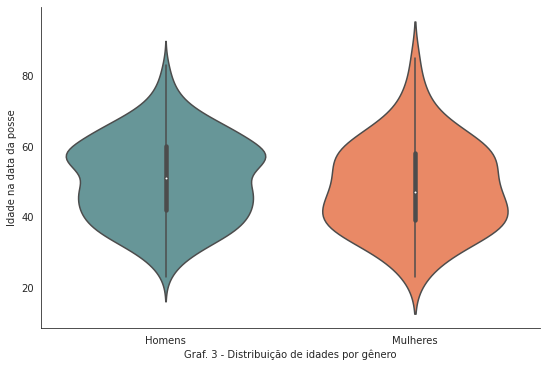

In [22]:
dist_idades = sns.catplot(kind='violin', data=df_dpessoais_56, x='sexo', y='idadeNaPosse', height=5, aspect=1.5, palette=two_colors)

dist_idades.set(xticklabels=['Homens', 'Mulheres'])
dist_idades.set_axis_labels('Graf. 3 - Distribuição de idades por gênero', 'Idade na data da posse')


### Gráfs. 2 e 3 - As mulheres são mais jovens
Os gráficos 2 e 3 demonstram que, na 56a Legislatura (a atual), as mulheres eleitas para a Câmara dos Deputados são, em geral, ligeiramente mais novas que os homens.
Embora sejam mulheres tanto o membro mais velho quando o mais novo da Casa, em sua maioria, as deputadas tendem a ser mais novas que os homens, com uma mediana ligeiramente menor, como vemos com mais clareza no gráfico 2.  

In [23]:
# Mulheres suplentes x mulheres titulares

df_dpessoais_56[df_dpessoais_56.sexo == 'F'].count()  # 84
titulares = df_dpessoais_56.groupby(['sexo', 'condicaoEleitoral']).count().reset_index()
titulares_pivot = titulares.pivot(columns='sexo', index='condicaoEleitoral', values='nome').reset_index()

titulares_pivot

sexo,condicaoEleitoral,F,M
0,Efetivado,1.0,13.0
1,Eleito,NaN,2.0
2,Não Eleito,NaN,2.0
3,Suplente,6.0,38.0
4,Titular,77.0,434.0


#### Deputadas titulares x suplentes
Um dos desafios das bases de dados df_dados_pessoais_56, que deu origem a df_dpessoais_56, e da df_deputados, com dados gerais, é que elas contém apenas os dados mais recentes de um deputado. Assim, no caso de um deputado ser reeleito, não temos como saber se, na sua primeira legislatura, ele era suplente ou titular. Temos apenas os dados da última legislatura. 
Nessa tabela, vemos que a proporção de suplentes é parecida entre homens e mulheres (6/77 para elas e 38/434 para eles).
Isso era esperado, uma vez que a posse numa cadeira da Câmara dos Deputados se dá pelo preenchimento de uma lista que mantém a proporcionalidade das eleições. Assim, isso parece reforçar a hipótese de que o sistema de lista e a proporcionalidade conseguem fazer uma distribuição relativamente equitativa, apesar do baixo número de mulheres no total. No entanto, essa hipótese precisa de mais aprofundamento. 


In [24]:
# Informações sobre a escolaridade dos deputados 

df_escola = df_dados_pessoais_56[['sexo','escolaridade', 'nome']]
escola1 = df_escola.groupby(['sexo', 'escolaridade']).count().reset_index()
escola1['percentual'] = escola1.apply(lambda row: int(row['nome']/84*100) if row['sexo'] == 'F' else int(row['nome']/489*100), axis=1)
escola1




,sexo,escolaridade,nome,percentual
0,F,Doutorado,3,3
1,F,Doutorado Incompleto,1,1
2,F,Ensino Fundamental,1,1
3,F,Ensino Médio,3,3
4,F,Mestrado,7,8
5,F,Mestrado Incompleto,2,2
6,F,Pós-Graduação,18,21
7,F,Superior,47,55
8,F,Superior Incompleto,2,2
9,M,Doutorado,14,2


In [25]:
# Outra visualização da tabela sobre escolaridade, que permite comparação melhor entre homens e mulheres. 

escola1_pivoted = escola1.pivot(columns='sexo', index='escolaridade').reset_index()
# escola5_pivoted.astype({'sexo': 'int32'}).dtypes
escola1_pivoted
# escola5.sexo.count()

escolaridade  nome        percentual      
sexo                              F      M          F     M
0                   Doutorado   3.0   14.0        3.0   2.0
1        Doutorado Incompleto   1.0    2.0        1.0   0.0
2          Ensino Fundamental   1.0    8.0        1.0   1.0
3                Ensino Médio   3.0   27.0        3.0   5.0
4     Ensino Médio Incompleto   NaN    3.0        NaN   0.0
5              Ensino Técnico   NaN    2.0        NaN   0.0
6                    Mestrado   7.0   35.0        8.0   7.0
7         Mestrado Incompleto   2.0    7.0        2.0   1.0
8         Primário Incompleto   NaN    1.0        NaN   0.0
9               Pós-Graduação  18.0   75.0       21.0  15.0
10                 Secundário   NaN    3.0        NaN   0.0
11      Secundário Incompleto   NaN    1.0        NaN   0.0
12                   Superior  47.0  269.0       55.0  55.0
13        Superior Incompleto   2.0   42.0        2.0   8.0

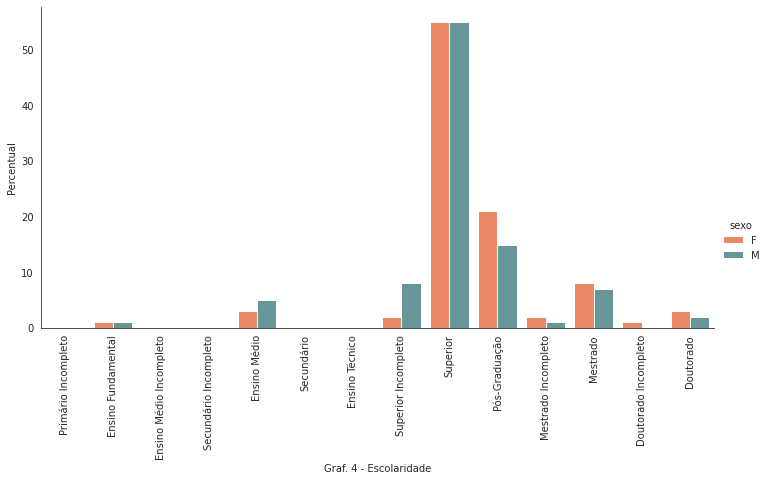

In [26]:
labels=['Primário Incompleto', 'Ensino Fundamental', 'Ensino Médio Incompleto', 'Secundário Incompleto',
                                  'Ensino Médio', 'Secundário', 'Ensino Técnico', 'Superior Incompleto', 'Superior',
                                  'Pós-Graduação', 'Mestrado Incompleto', 'Mestrado', 'Doutorado Incompleto', 'Doutorado']
escolaridade = sns.catplot(kind='bar', data=escola1, x='escolaridade', y='percentual', hue='sexo', height=5, aspect=2, palette=two_colors,
                           order=labels)
escolaridade.set_axis_labels("Graf. 4 - Escolaridade", "Percentual")
plt.setp(escolaridade.ax.get_xticklabels(), rotation=90)
plt.show(escolaridade)

### Gráf. 4 - Elite cultural
O gráfico 4 mostra, por um lado, que a maior parte dos deputados, homens e mulheres, tem um nível de escolaridade alto. 
Ele também compara a escolaridade entre homens e mulheres, mostrando que ela é igual no nível superior.
Comparando os outros níveis, vemos que as mulheres têm, em geral, maior escolaridade que os homens. Enquanto há um percentual maior de homens nas escolaridades mais baixas, há um percentual maior de mulheres nas mais altas. 
É preciso investigar se isso é um reflexo da escolaridade em geral na sociedade, ou se isso demonstra que as mulheres precisam ser mais qualificadas que homens para conseguir competir com eles pelos mesmos cargos, ou ainda outra hipótese. 

### Conclusões e Achados

Este trabalho consistiu numa análise exploratória sobre a presença feminina na Câmara dos Deputados. **As mulheres, que correspondem à metade da população brasileira, estão bem representadas nessa instituição? Qual é o perfil dessas mulheres?**

Os dados utilizados foram obtidos do portal de Dados Abertos da Câmara dos Deputados. Durante a pesquisa, alguns problemas surgiram, como o número total de deputados por legislatura. Observar essa discrepância me fez levantar a hipótese de que o número da base de dados oscile devido à maior ou menor entrada de suplentes, que assumem o lugar de algum deputado titular que pediu vacância por algum motivo. Essa discrepância causou grandes oscilações no gráfico de evolução histórica. 

Uma forma de tentar isolar esse efeito seria através da base de dados pessoais do portal, que foi feita por scrapping na API do site apenas para a 56a Legislatura (a atual). No entanto, essa base só conta com os dados atualizados pela última legislatura de um deputado. Assim, não teria como descobrir, por essa base de dados, se um deputado tinha sido suplente em uma legislatura e tenha sido eleito como titular na próxima. Assim, seria preciso explorar outras bases de dados para poder  comprovar essa hipótese e tentar isolar esse efeito.

Descontados esses problemas, foi possível fazer algumas descobertas sobre o perfil dessas mulheres. 

Analisando a evolução no tempo, vemos que apenas em 1934 foi eleita a primeira mulher para a Câmara dos Deputados, e que apenas em 1967 começou um aumento no número de mulheres eleitas. **Ainda assim, o ritmo desse aumento é tímido desde então, muito baixo para conseguir diminuir o déficit de representatividade que ainda existe.** Numa análise posterior, seria interessante calcular quando haveria equiparação entre os gêneros na Casa, mantendo esse tímido ritmo. 

Observando a faixa etária, vimos que as mulheres eleitas para a Câmara dos Deputados são, em geral, **ligeiramente mais novas que os homens**. A mediana das idades é ligeiramente menor. Isso faz levantar algumas perguntas, como: as mulheres mais velhas teriam menos interesse em se candidatar? Ou mulheres mais velhas não teriam o mesmo sucesso nas eleições? 

Por fim, observamos os níveis de escolaridade dos Deputados. O relativo alto índice escolar, que possivelmente não reflete os níveis da sociedade brasileira em geral, sugere que a **elite econômica e cultural domina esse ambiente de debate e decisões que é a Câmara**. Porque eles estão sobrerrepresentados lá? Seria porque as elites se interessam mais por política? Ou teriam as elites mais dinheiro ou acesso a recursos para suas campanhas? Ou seriam elas mais votadas por serem vistas como mais competentes pelos eleitores? São perguntas que merecem um aprofundamento posterior. 

**No que tange às mulheres, é interessante notar que seu nível educacional é, em geral, maior do que os dos homens.** É preciso investigar se isso é um reflexo da escolaridade em geral na sociedade, ou se isso demonstra que as mulheres precisam ser mais qualificadas que homens para conseguir competir com eles pelos mesmos cargos, ou ainda outra hipótese.

Assim, nesta pequena análise exploratória, foi possível ver as limitações das fontes, mostrando a exigência de se explorar outras bases para refinar as conclusões. Desse pequeno perfil, foi possível levantar várias perguntas que podem ser objeto de novas investigações. 